In [10]:
import numpy as np
import sqlite3
import pickle
import cv2
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt



import embedding_resnet_final
import histograms_commented


## Connect to the database and save all paths

In [11]:
database_name = "database_all_images.db"
root_folder = r"D:/data/image_data"

conn = sqlite3.connect(database_name)
c = conn.cursor()
conn.commit()


In [12]:
c.execute("SELECT Path FROM Images")

# Fetch all results
paths_tuples = c.fetchall()  # This will be a list of tuples

# Convert list of tuples to a list of strings
database_image_paths = [path[0] for path in paths_tuples]  # Extract the first element of each tuple

# Verify the paths
for path in database_image_paths[:10]:  # Print the first 10 paths for verification
    print(path)

D:/data/image_data\weather_image_recognition\dew\2208.jpg
D:/data/image_data\weather_image_recognition\dew\2209.jpg
D:/data/image_data\weather_image_recognition\dew\2210.jpg
D:/data/image_data\weather_image_recognition\dew\2211.jpg
D:/data/image_data\weather_image_recognition\dew\2212.jpg
D:/data/image_data\weather_image_recognition\dew\2213.jpg
D:/data/image_data\weather_image_recognition\dew\2214.jpg
D:/data/image_data\weather_image_recognition\dew\2215.jpg
D:/data/image_data\weather_image_recognition\dew\2216.jpg
D:/data/image_data\weather_image_recognition\dew\2217.jpg


In [13]:
# Load the ResNet50 model pre-trained on ImageNet (taktes around 2 sec)
base_model = ResNet50(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

In [14]:
def load_embeddings_and_paths(embeddings_path, image_paths_path):
    with open(embeddings_path, 'rb') as f:
        embeddings = pickle.load(f)
    with open(image_paths_path, 'rb') as f:
        image_paths = pickle.load(f)
    return embeddings, image_paths

In [15]:
# Load embeddings and histograms from pickle files
with open('embeddings_all.pkl', 'rb') as f:
    embeddings = pickle.load(f)

histograms = histograms_commented.load_histograms_from_file("histograms_all_images_0608.pkl")

In [16]:
def find_similar_images(input_img_path, model, embeddings, image_paths, histograms, top_n_embeddings=1000, top_n_histograms=5):
    """
    This function finds images in the database that are most similar to the input image based on a combination of embeddings and histograms.

    Input:
    - input_img_path: The file path of the input image.
    - model: The model used to extract embeddings.
    - embeddings: A NumPy array containing the embeddings of all images in the database.
    - image_paths: A list of paths to the images corresponding to the embeddings.
    - histograms: A dictionary where keys are image paths and values are the corresponding histograms.
    - top_n_embeddings: Number of top similar images to select based on embeddings (default is 1000).
    - top_n_histograms: Number of top similar images to select based on histograms (default is 5).

    Output:
    - A list of tuples where each tuple contains an image path and the corresponding similarity score.
      The list is ordered by similarity, with the most similar image first.
    """
    # Step 1: Find similar images based on embeddings
    input_embedding = embedding_resnet_final.extract_embedding(input_img_path, model)
    if input_embedding is None:
        print(f"Failed to extract embedding for input image: {input_img_path}")
        return []
    
    # Use Nearest Neighbors for efficient similarity search based on embeddings
    nbrs_embeddings = NearestNeighbors(n_neighbors=len(embeddings), algorithm='auto', metric='euclidean').fit(embeddings)
    distances_embeddings, indices_embeddings = nbrs_embeddings.kneighbors([input_embedding])
    #print(len(image_paths))
    # Select the top N closest images based on normalized embedding distances
    closest_indices = indices_embeddings[0][:top_n_embeddings]
    #print(len(closest_indices))
    closest_image_paths = [image_paths[i] for i in closest_indices]
    closest_histograms = [histograms[image_paths[i]] for i in closest_indices if image_paths[i] in histograms]

    #print(f"Top {top_n_embeddings} embeddings Similarities Calculated")

    # Load the input image
    input_image = cv2.imread(input_img_path)
    if input_image is None:
        print(f"Failed to load input image: {input_img_path}")
        return []


    # Extract histogram for the input image
    input_histogram = histograms_commented.calculate_histogram(input_image, "HSV")
    if input_histogram is None:
        print(f"Failed to extract histogram for input image: {input_img_path}")
        return []

    # Step 2: Find similar images based on histograms among the top embedding matches
    nbrs_histograms = NearestNeighbors(n_neighbors=top_n_embeddings, algorithm='auto', metric='euclidean').fit(closest_histograms)
    distances_histograms, indices_histograms = nbrs_histograms.kneighbors([input_histogram])

    distances_histograms = distances_histograms / np.max(distances_histograms)
    print(np.max(distances_histograms[0]))
    print(f"Top {top_n_histograms} histograms Similarities Calculated")

    # Retrieve the top N similar images based on histogram similarity
    similar_images = [(closest_image_paths[indices_histograms[0][i]], distances_histograms[0][i]) for i in range(top_n_histograms)]
    
    return similar_images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1.0
Top 5 histograms Similarities Calculated
Showing Plot...


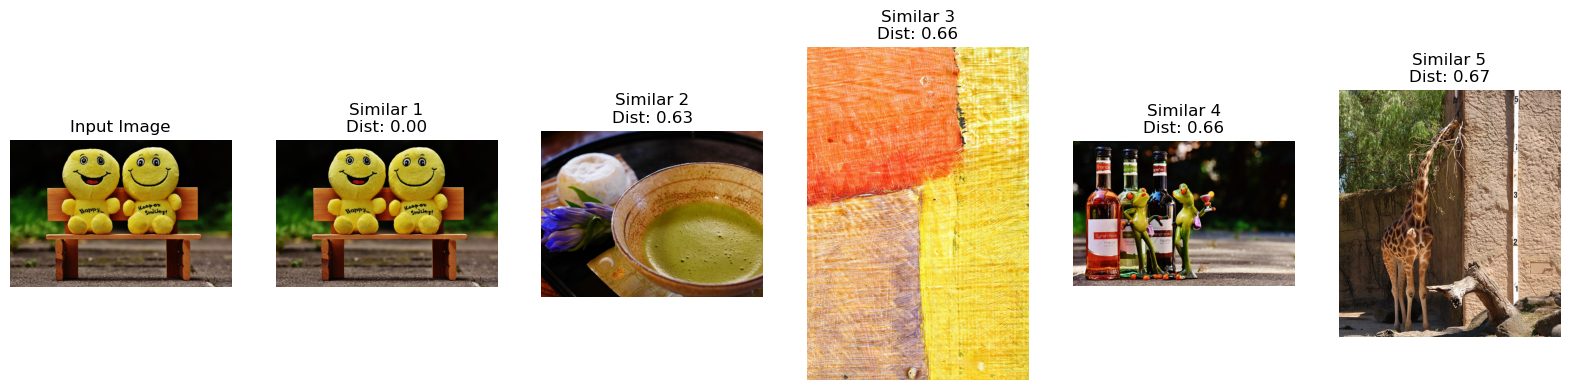

In [18]:

input_img_path = "images/0196.png"
similar_images = find_similar_images(input_img_path, model, embeddings, database_image_paths, histograms)
#print("Plotting now similar images...")
#print(similar_images)

histograms_commented.display_images(input_img_path, similar_images)

## 5 Input Images 

In [19]:

def find_similar_images_from_path(input_img_paths, model, embeddings, image_paths, histograms, top_n_embeddings=1000, top_n_histograms=5):
    """
    This function finds images in the database that are most similar to the summarized input images 
    based on a combination of embeddings and histograms.

    Input:
    - input_img_paths: A list of file paths of the input images.
    - model: The model used to extract embeddings.
    - embeddings: A NumPy array containing the embeddings of all images in the database.
    - image_paths: A list of paths to the images corresponding to the embeddings.
    - histograms: A dictionary where keys are image paths and values are the corresponding histograms.
    - top_n_embeddings: Number of top similar images to select based on embeddings (default is 1000).
    - top_n_histograms: Number of top similar images to select based on histograms (default is 5).

    Output:
    - A list of tuples where each tuple contains an image path and the corresponding similarity score.
      The list is ordered by similarity, with the most similar image first.
    """
    # Step 1: Extract embeddings for all input images and calculate the summarized embedding
    input_embeddings = []
    input_histograms = []
    
    for img_path in input_img_paths:
        embedding = embedding_resnet_final.extract_embedding(img_path, model)
        if embedding is not None:
            input_embeddings.append(embedding)
        else:
            print(f"Failed to extract embedding for input image: {img_path}")

        image = cv2.imread(img_path)
        if image is not None:
            histogram = histograms_commented.calculate_histogram(image, "HSV")
            input_histograms.append(histogram)
        else:
            print(f"Failed to load or process image: {img_path}")

    if not input_embeddings or not input_histograms:
        print("No valid embeddings or histograms found for the input images.")
        return []

    summarized_embedding = np.mean(input_embeddings, axis=0)
    summarized_histogram = np.mean(input_histograms, axis=0)

    # Step 2: Use the summarized embedding to find the top N closest images
    nbrs_embeddings = NearestNeighbors(n_neighbors=len(embeddings), algorithm='auto', metric='euclidean').fit(embeddings)
    distances_embeddings, indices_embeddings = nbrs_embeddings.kneighbors([summarized_embedding])
    
    # Select the top N closest images based on normalized embedding distances
    closest_indices = indices_embeddings[0][:top_n_embeddings]
    closest_image_paths = [image_paths[i] for i in closest_indices]
    closest_histograms = [histograms[image_paths[i]] for i in closest_indices if image_paths[i] in histograms]

    print(f"Top {top_n_embeddings} embeddings Similarities Calculated")

    # Step 3: Use the summarized histogram to find the top N closest images among the top embedding matches
    nbrs_histograms = NearestNeighbors(n_neighbors=top_n_histograms, algorithm='auto', metric='euclidean').fit(closest_histograms)
    distances_histograms, indices_histograms = nbrs_histograms.kneighbors([summarized_histogram])

    print(f"Top {top_n_histograms} histograms Similarities Calculated")

    # Retrieve the top N similar images based on histogram similarity
    similar_images = [(closest_image_paths[indices_histograms[0][i]], distances_histograms[0][i]) for i in range(top_n_histograms)]
    
    return similar_images

def display_images_from_paths(image_paths):
    plt.figure(figsize=(20, 5))
    for i, image_path in enumerate(image_paths, start=1):
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.subplot(1, len(image_paths), i)
        plt.imshow(image_rgb)
        plt.title(f'Image {i}')
        plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Top 1000 embeddings Similarities Calculated
Top 5 histograms Similarities Calculated


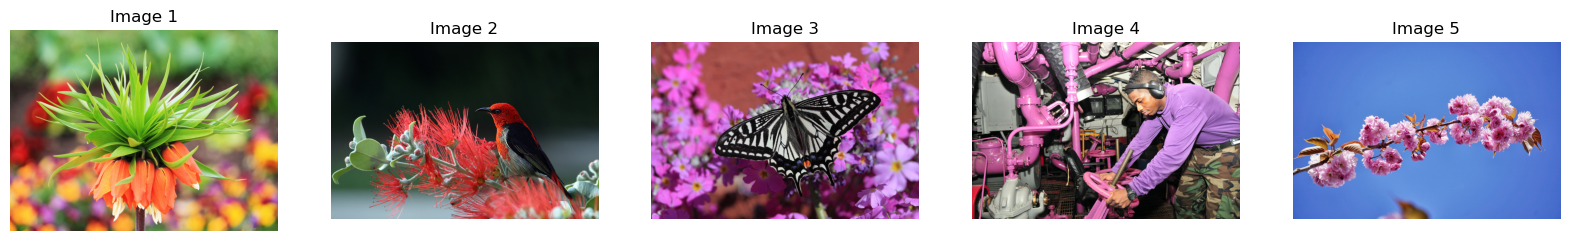

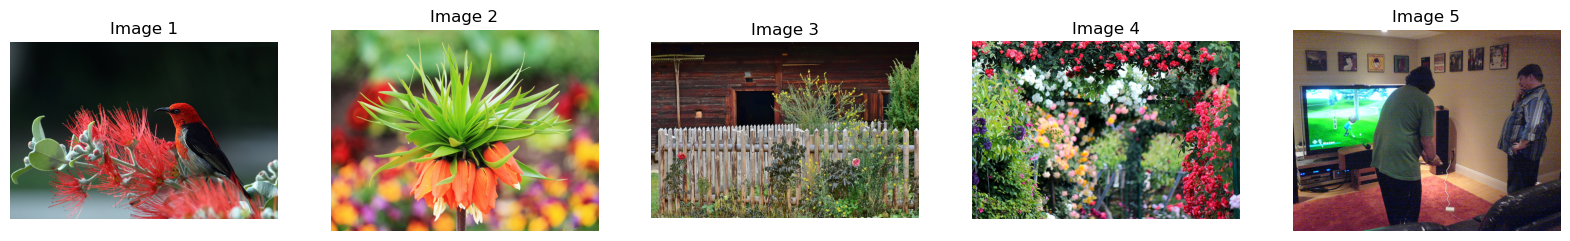

In [20]:
input_img_paths = ["images/0803.png",
                   "images/0853.png",
                   "images/0882.png",
                   "images/0888.png",
                   "images/0898.png"]

similar_images = find_similar_images_from_path(input_img_paths, model, embeddings, database_image_paths, histograms, top_n_embeddings=1000, top_n_histograms=5)

# Display input images
display_images_from_paths(input_img_paths)

# Extract image paths from the similar_images list (which contains tuples of (path, similarity))
similar_image_paths = [img[0] for img in similar_images]

# Display similar images
display_images_from_paths(similar_image_paths)